# Stable Difussion

## Set Up

In [1]:
from diffusers import AutoencoderKL, DDIMScheduler, UNet2DConditionModel
import numpy as np
import torch
from pathlib import Path
from PIL import Image
from tqdm.auto import tqdm
from torchvision import transforms
import matplotlib.pyplot as plt
from IPython.display import clear_output
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer

device = 'cuda' if torch.cuda.is_available() else 'cpu'

c:\Users\Usuario\anaconda3\envs\synthetic\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Pre-trained models

In [4]:
model_id = 'sd-legacy/stable-diffusion-v1-5'
# Load the autoencoder model which will be used to decode the latents into image space.
vae = AutoencoderKL.from_pretrained(model_id, subfolder="vae")
# Diffusion - predict noise in x_noised
unet = UNet2DConditionModel.from_pretrained(model_id, subfolder="unet") 

# Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = CLIPTokenizer.from_pretrained(model_id, subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained(model_id, subfolder="text_encoder")

# Inverse Diffusion - given x_noised and pred_noise obtain x_t
scheduler = DDIMScheduler.from_pretrained(model_id, subfolder="scheduler") 

vae.to(device)
unet.to(device)
text_encoder.to(device)

CLIPTextModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 768)
      (position_embedding): Embedding(77, 768)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e

## Text to Image

### Wrap everything in a Pipeline

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
100%|██████████| 50/50 [00:14<00:00,  3.37it/s]


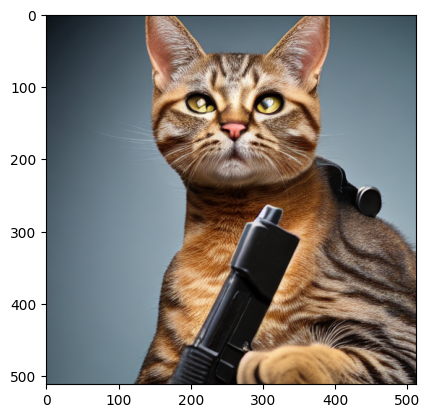

In [6]:
from diffusers import StableDiffusionPipeline

pipeline = StableDiffusionPipeline(
    vae=vae,
    text_encoder=text_encoder,
    tokenizer=tokenizer,
    unet=unet,
    scheduler=scheduler,
    safety_checker=None,
    feature_extractor=None,
)

pipeline.to(device)

prompt = "A cat with a gun"

images = pipeline(
        prompt=prompt,
        num_inference_steps=50,
        guidance_scale=7.5,
    )

plt.imshow(images.images[0])
plt.show()

### Manual Diffusion

In [7]:
prompt = ["A cat"]

tokenized_prompt = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

print(f'shape of  tokenized_prompt: {tokenized_prompt.input_ids.shape}')
# Move to the same device as the model.
tokenized_prompt = tokenized_prompt.to(device)

print(tokenized_prompt.input_ids)

shape of  tokenized_prompt: torch.Size([1, 77])
tensor([[49406,   320,  2368, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407]], device='cuda:0')


In [8]:
# Encode the text and get the text embeddings.
with torch.no_grad():
    text_embeddings = text_encoder(**tokenized_prompt).last_hidden_state

print(f'shape of text_embeddings: {text_embeddings.shape}')

shape of text_embeddings: torch.Size([1, 77, 768])


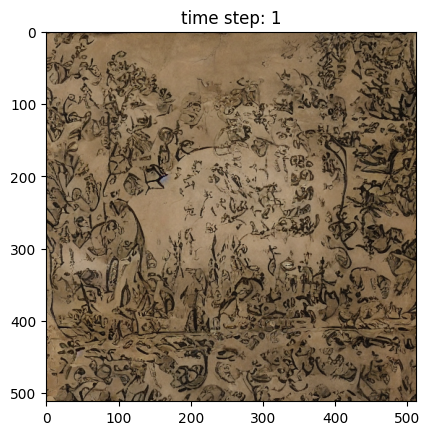

In [9]:
# set the inference time steps to be 50
scheduler.set_timesteps(num_inference_steps=50)

generator = torch.cuda.manual_seed_all(42)

latents = torch.randn((1, unet.in_channels, 64, 64), generator=generator, device=device).to(device)

for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
    
    with torch.no_grad():
        # predict the noise residual
        noise_pred = unet(latents, t, encoder_hidden_states=text_embeddings).sample # Text conditioning is passed in here
        latents = scheduler.step(noise_pred, t, latents).prev_sample
        
        if i%5==0:
            latents_scaled = 1 / vae.config.scaling_factor * latents
            with torch.no_grad():
                image = vae.decode(latents_scaled).sample
            
            image = (image / 2 + 0.5).clamp(0, 1)
            image = image.detach().cpu().squeeze(0).permute(1, 2, 0).numpy()
            
            plt.imshow(image)
            plt.title(f'time step: {t}')
            clear_output(wait=True)
            plt.show()
            
latents_scaled = 1 / vae.config.scaling_factor * latents
with torch.no_grad():
    image = vae.decode(latents_scaled).sample

image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().squeeze(0).permute(1, 2, 0).numpy()

plt.imshow(image)
plt.title(f'time step: {t}')
clear_output(wait=True)
plt.show()

### Classifier-free Guidance

It turns out that even with all of the effort put into making the text conditioning as useful as possible, the model still tends to default to relying mostly on the noisy input image rather than the prompt when making its predictions. In a way, this makes sense - many captions are only loosely related to their associated images and so the model learns not to rely too heavily on the descriptions! However, this is undesirable when it comes time to generate new images - if the model doesn’t follow the prompt then we may get images out that don’t relate to our description at all.

In [10]:
prompt = ["A cat", ""]

tokenized_prompt = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

print(f'shape of  tokenized_prompt: {tokenized_prompt.input_ids.shape}')
# Move to the same device as the model.
tokenized_prompt = tokenized_prompt.to(device)

# Encode the text and get the text embeddings.
with torch.no_grad():
    text_embeddings = text_encoder(**tokenized_prompt).last_hidden_state

print(f'shape of text_embeddings: {text_embeddings.shape}')

shape of  tokenized_prompt: torch.Size([2, 77])
shape of text_embeddings: torch.Size([2, 77, 768])


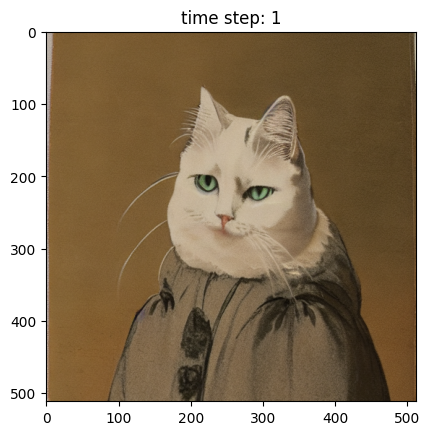

In [11]:
# set the inference time steps to be 50
scheduler.set_timesteps(num_inference_steps=50)

guidance_scale = 7.5

generator = torch.cuda.manual_seed_all(42)
latents = torch.randn((1, unet.config.in_channels, 64, 64), generator=generator, device=device).to(device)

for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
    
    latent_model_inputs = torch.cat([latents] * 2)
    
    with torch.no_grad():
        # predict the noise residual
        noise_pred = unet(latent_model_inputs, t, encoder_hidden_states=text_embeddings).sample
        
    # perform guidance
    noise_pred_text, noise_pred_uncond = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
    
    # compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, t, latents).prev_sample

    
    if i%5==0 or t==1 :
        latents_scaled = 1 / vae.config.scaling_factor * latents
        with torch.no_grad():
            image = vae.decode(latents_scaled).sample
        
        image = (image / 2 + 0.5).clamp(0, 1)
        image = image.detach().cpu().squeeze(0).permute(1, 2, 0).numpy()
        
        plt.imshow(image)
        plt.title(f'time step: {t}')
        clear_output(wait=True)
        plt.show()
        
latents_scaled = 1 / vae.config.scaling_factor * latents
with torch.no_grad():
    image = vae.decode(latents_scaled).sample

image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().squeeze(0).permute(1, 2, 0).numpy()

plt.imshow(image)
plt.title(f'time step: {t}')
clear_output(wait=True)
plt.show()

### Change the Scheduler for Better Results

In [12]:
prompt = ["A cat", ""]

tokenized_prompt = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

print(f'shape of  tokenized_prompt: {tokenized_prompt.input_ids.shape}')
# Move to the same device as the model.
tokenized_prompt = tokenized_prompt.to(device)

# Encode the text and get the text embeddings.
with torch.no_grad():
    text_embeddings = text_encoder(**tokenized_prompt).last_hidden_state

print(f'shape of text_embeddings: {text_embeddings.shape}')

shape of  tokenized_prompt: torch.Size([2, 77])
shape of text_embeddings: torch.Size([2, 77, 768])


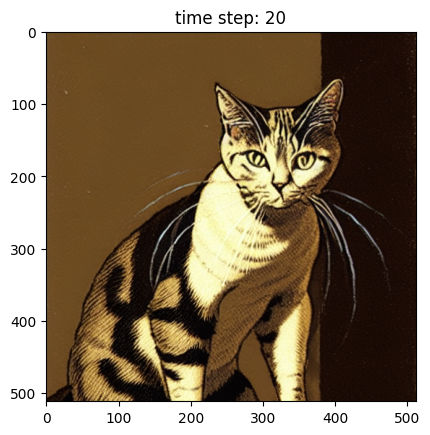

In [13]:
from diffusers import DPMSolverMultistepScheduler

scheduler = DPMSolverMultistepScheduler.from_pretrained(model_id, subfolder="scheduler", algorithm_type="sde-dpmsolver++")
scheduler.set_timesteps(num_inference_steps=50)


guidance_scale = 7.5

generator = torch.cuda.manual_seed_all(42)
latents = torch.randn((1, unet.config.in_channels, 64, 64), generator=generator, device=device).to(device)

for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
    
    latent_model_inputs = torch.cat([latents] * 2)
    
    with torch.no_grad():
        # predict the noise residual
        noise_pred = unet(latent_model_inputs, t, encoder_hidden_states=text_embeddings).sample
        
    # perform guidance
    noise_pred_text, noise_pred_uncond = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
    
    # compute the previous noisy sample x_t -> x_t-1
    extra_step_kwargs = {}
    extra_step_kwargs["generator"] = torch.Generator().manual_seed(42)
    latents = scheduler.step(noise_pred, t, latents, 
                           generator = generator
                             ).prev_sample

    
    if i%5==0:
        latents_scaled = 1 / vae.config.scaling_factor * latents
        with torch.no_grad():
            image = vae.decode(latents_scaled).sample
        
        image = (image / 2 + 0.5).clamp(0, 1)
        image = image.detach().cpu().squeeze(0).permute(1, 2, 0).numpy()
        
        plt.imshow(image)
        plt.title(f'time step: {t}')
        clear_output(wait=True)
        plt.show()
        
latents_scaled = 1 / vae.config.scaling_factor * latents
with torch.no_grad():
    image = vae.decode(latents_scaled).sample

image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().squeeze(0).permute(1, 2, 0).numpy()

plt.imshow(image)
plt.title(f'time step: {t}')
clear_output(wait=True)
plt.show()

## Image to Image Pipeline

In [14]:
from diffusers import StableDiffusionImg2ImgPipeline

img2img_pipe = StableDiffusionImg2ImgPipeline(
    vae=vae,
    text_encoder=text_encoder,
    tokenizer=tokenizer,
    unet=unet,
    scheduler=scheduler,
    safety_checker=None,
    feature_extractor=None,
)

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img.StableDiffusionImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


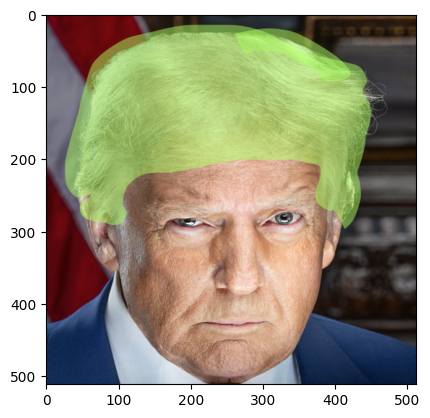

In [16]:
img2img_pipe.to(device)

image = Image.open("data/dt_hair.png").resize((512,512)).convert("RGB")

plt.imshow(image)
plt.show()

100%|██████████| 25/25 [00:07<00:00,  3.51it/s]


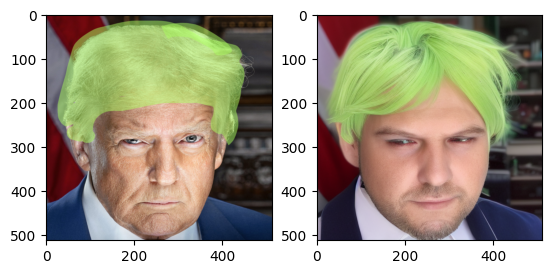

In [19]:
gen_image = img2img_pipe(prompt="a man with neon green hair",
                            image=image, 
                            strength=0.5, 
                            guidance_scale=7.5, 
                            num_inference_steps=50,
                            ).images[0]

plt.subplot(1,2,1)
plt.imshow(image)
plt.subplot(1,2,2)
plt.imshow(gen_image)
# clear_output(wait=True)
plt.show()

## Inpainting Image

In [20]:
from diffusers import StableDiffusionInpaintPipeline

inpaint_pipe = StableDiffusionInpaintPipeline.from_pipe(img2img_pipe)

inpaint_pipe.to(device)

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint.StableDiffusionInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


StableDiffusionInpaintPipeline {
  "_class_name": "StableDiffusionInpaintPipeline",
  "_diffusers_version": "0.35.2",
  "feature_extractor": [
    null,
    null
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "DPMSolverMultistepScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

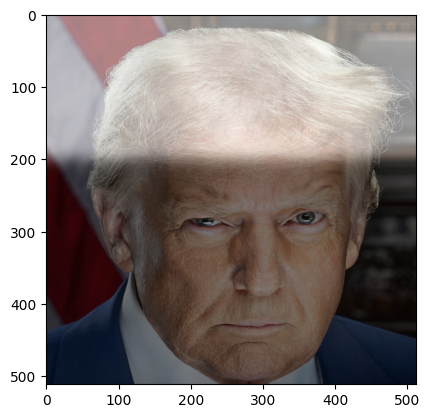

In [22]:
from scipy.ndimage import gaussian_filter

ref_image = Image.open('data/dt.png').crop((300,200,2200,2300)).resize((512,512)).convert('RGB')

mask = np.zeros((512,512), dtype=np.float32)
mask[0:200, :] = 1.0
mask = gaussian_filter(mask, sigma=10)
mask=Image.fromarray((mask * 255).astype(np.uint8))

# plot the mask and inv mask
plt.imshow(ref_image)
plt.imshow(mask,cmap='grey',alpha=0.5)
plt.show()

100%|██████████| 15/15 [00:04<00:00,  3.38it/s]


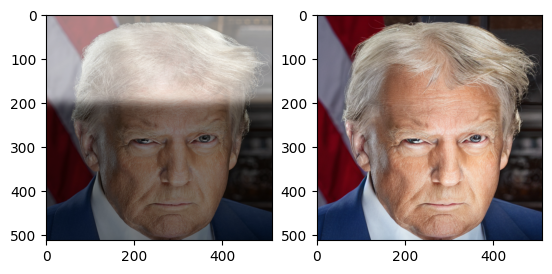

In [24]:
gen_image = inpaint_pipe(prompt="black dark hair, jay z",
                            image=ref_image, 
                            mask_image=mask,
                            strength=0.3, 
                            guidance_scale=7.5, 
                            num_inference_steps=50,
                            ).images[0]

plt.subplot(1,2,1)
plt.imshow(ref_image)
plt.imshow(mask,cmap='grey',alpha=0.5)
plt.subplot(1,2,2)
plt.imshow(gen_image)
# clear_output(wait=True)
plt.show()